In [185]:
import pandas as pd
import numpy as np
import tensorflow as tf
import nltk
from nltk.corpus import stopwords
import re
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPool1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer


In [186]:
dataset_1 = pd.read_csv('..\Datasets\Emotion_final.csv')
dataset_2 = pd.read_csv('..\Datasets\Text_emotion.csv')

<AxesSubplot:xlabel='Emotion', ylabel='count'>

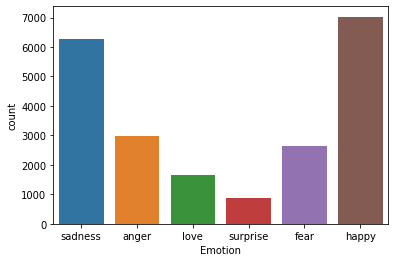

In [187]:
import seaborn as sns

sns.countplot(x='Emotion', data=dataset_1)

In [272]:
def preprocess_text(text):
    #Remove punctuation and numbers
    text = re.sub('[^a-zA-Z]', ' ', text)
    #Single Character removal
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)

    #Removing multiple spaces
    text = re.sub(r"\s+", ' ', text)
    text = text.lower()

    return text

In [189]:
train, test = train_test_split(dataset_1, test_size= 0.3, random_state=111)
train, val = train_test_split(train, test_size=0.3, random_state=111)



In [190]:
X_train = train.Text
X_test = test.Text
X_val = val.Text

y_train = train.Emotion
y_test = test.Emotion
y_val = val.Emotion


In [191]:
from sklearn.utils import class_weight
class_weights = list(class_weight.compute_class_weight(
    class_weight = 'balanced', 
    classes = np.unique(dataset_1['Emotion']), 
    y = dataset_1['Emotion']))

In [192]:
dataset_1.Emotion.unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'happy'],
      dtype=object)

In [193]:
class_weights.sort()

In [194]:
class_weights

[0.5088206003698962,
 0.5708699122106944,
 1.194954894754427,
 1.348604826546003,
 2.179463741620963,
 4.068828213879408]

In [195]:
weights = {}

for index, weight in enumerate(class_weights):
    weights[index] = weight

In [196]:
weights

{0: 0.5088206003698962,
 1: 0.5708699122106944,
 2: 1.194954894754427,
 3: 1.348604826546003,
 4: 2.179463741620963,
 5: 4.068828213879408}

In [197]:
dataset_train = tf.data.Dataset.from_tensor_slices((train['Text'].values, train['Emotion'].values))
dataset_test = tf.data.Dataset.from_tensor_slices((test['Text'].values, test['Emotion'].values))
dataset_val = tf.data.Dataset.from_tensor_slices((val['Text'].values, val['Emotion'].values))


In [198]:
for text, target in dataset_train.take(5):
    print(f'Text: {text}, Emotion: {target}')

Text: b'i still very much feel submissive', Emotion: b'sadness'
Text: b'im inclined to think his feeling disturbed is at least partly due to the manifest problems with the tactic', Emotion: b'sadness'
Text: b'i feel guilty a little and also mildly worried but not bad enough to actually pursue anything', Emotion: b'sadness'
Text: b'i feel like the dust in me has been shaken and still has not settled', Emotion: b'fear'
Text: b'im not feeling very graceful today', Emotion: b'happy'


In [199]:
table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(['sadness', 'anger', 'love', 'surprise', 'fear', 'happy']),
        values=tf.constant([0,1,2,3,4,5]),
    ),
    default_value=tf.constant(-1),
    name = "target_encoding"
)

@tf.function
def target(x):
    return table.lookup(x)

In [200]:
def show_batch(dataset, size=5):
    for batch, label in dataset.take(size):
        print(batch.numpy())
        print(target(label).numpy())

In [201]:
show_batch(dataset_test, 6)

b'im just feeling whiney'
0
b'It was Blackberry who bullied the stupefied Pipkin to his feet and forced him to limp the few yards to the grave'
3
b'i am standing so close to said cow her name is gabriella btw i feel rude calling her a cow'
1
b'i look flaky or streaky please feel free to tell me'
5
b'i feel like i was assaulted by a titanium hedgehog'
4
b'i feel anything for relationships the doomed one'
0


In [202]:
def fetch(text, labels):
    return text, tf.one_hot(target(labels), 6)

In [203]:
train_data_f = dataset_train.map(fetch)
test_data_f = dataset_test.map(fetch)
val_data_f = dataset_val.map(fetch)

In [204]:
next(iter(train_data_f))

(<tf.Tensor: shape=(), dtype=string, numpy=b'i still very much feel submissive'>,
 <tf.Tensor: shape=(6,), dtype=float32, numpy=array([1., 0., 0., 0., 0., 0.], dtype=float32)>)

In [205]:
train_data, train_labels = next(iter(train_data_f.batch(5)))
train_data, train_labels

(<tf.Tensor: shape=(5,), dtype=string, numpy=
 array([b'i still very much feel submissive',
        b'im inclined to think his feeling disturbed is at least partly due to the manifest problems with the tactic',
        b'i feel guilty a little and also mildly worried but not bad enough to actually pursue anything',
        b'i feel like the dust in me has been shaken and still has not settled',
        b'im not feeling very graceful today'], dtype=object)>,
 <tf.Tensor: shape=(5, 6), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1.]], dtype=float32)>)

In [206]:
import tensorflow_hub as hub
embedding = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"
hub_layer = hub.KerasLayer(embedding, output_shape=[128], input_shape=[], dtype=tf.string, trainable=True)

hub_layer(train_data[:1])

<tf.Tensor: shape=(1, 128), dtype=float32, numpy=
array([[ 2.59699106e-01,  3.80535377e-03,  1.15070976e-01,
         2.20660448e-01,  5.86057827e-02, -7.05655515e-02,
         2.86433436e-02, -1.34522036e-01, -4.81358320e-02,
        -1.07280444e-02,  1.38860181e-01, -1.34751588e-01,
        -7.35047832e-02, -1.37675643e-01, -6.30882084e-02,
         1.52496338e-01,  4.78207320e-02, -5.47323041e-02,
        -1.27302408e-01,  3.93812023e-02,  1.55977115e-01,
        -7.36882538e-02, -9.56825446e-03, -7.30612949e-02,
         4.50265110e-02, -5.08982055e-02,  2.69979298e-01,
         2.19272356e-02, -2.72957738e-02, -5.15200151e-03,
         1.10490352e-01,  8.42242390e-02,  1.48596251e-02,
         6.01801164e-02,  1.60738319e-01,  8.69318098e-02,
        -1.97651550e-01, -1.27742842e-01,  1.03010565e-01,
         1.95083469e-01, -2.37989724e-01, -3.49473357e-02,
        -1.40261024e-01,  1.12089226e-02,  4.71913293e-02,
         4.78265584e-02, -6.86534122e-02,  3.36280875e-02,
      

In [207]:
model = tf.keras.Sequential()
model.add(hub_layer)
for units in [128,128,64,32]:
    model.add(tf.keras.layers.Dense(units, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(6, activation='softmax'))

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 128)               124642688 
                                                                 
 dense_32 (Dense)            (None, 128)               16512     
                                                                 
 dropout_24 (Dropout)        (None, 128)               0         
                                                                 
 dense_33 (Dense)            (None, 128)               16512     
                                                                 
 dropout_25 (Dropout)        (None, 128)               0         
                                                                 
 dense_34 (Dense)            (None, 64)                8256      
                                                                 
 dropout_26 (Dropout)        (None, 64)              

In [298]:
model2 = tf.keras.Sequential()
model2.add(hub_layer)
for units in [128,128,64,32]:
    model2.add(tf.keras.layers.Dense(units, activation='relu'))
    model2.add(tf.keras.layers.Dropout(0.3))
model2.add(tf.keras.layers.Dense(13, activation='softmax'))

model2.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 128)               124642688 
                                                                 
 dense_45 (Dense)            (None, 128)               16512     
                                                                 
 dropout_34 (Dropout)        (None, 128)               0         
                                                                 
 dense_46 (Dense)            (None, 128)               16512     
                                                                 
 dropout_35 (Dropout)        (None, 128)               0         
                                                                 
 dense_47 (Dense)            (None, 64)                8256      
                                                                 
 dropout_36 (Dropout)        (None, 64)              

In [208]:
model_LTSM = tf.keras.Sequential()

model_LTSM.add(hub_layer)

model_LTSM.add(tf.keras.layers.Reshape( target_shape=(128 , 1 ) ))

model_LTSM.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)))

model_LTSM.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)))

for units in [128, 64 ]:

  model_LTSM.add(tf.keras.layers.Dense(units, activation='relu'))

  model_LTSM.add(tf.keras.layers.Dropout(0.3))

model_LTSM.add(tf.keras.layers.Dense(13, activation='softmax'))



model_LTSM.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 128)               124642688 
                                                                 
 reshape_4 (Reshape)         (None, 128, 1)            0         
                                                                 
 bidirectional_8 (Bidirectio  (None, 128, 64)          8704      
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 32)               10368     
 nal)                                                            
                                                                 
 dense_37 (Dense)            (None, 128)               4224      
                                                                 
 dropout_28 (Dropout)        (None, 128)             

In [299]:
model.compile(optimizer='adam',
loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
metrics=['accuracy'])

In [300]:
model2.compile(optimizer='adam',
loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
metrics=['accuracy'])

In [210]:
train_data_f = train_data_f.shuffle(70000).batch(512)
test_data_f = test_data_f.batch(512)
val_data_f = val_data_f.batch(512)

In [211]:
history = model.fit(train_data_f,
                    epochs=30,
                    validation_data = val_data_f,
                    verbose = 1,
                    class_weight = weights)

Epoch 1/30


c:\Users\ifeol\anaconda3.1\envs\DevEnv\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


21/21 [==============================] - 29s 1s/step - loss: 2.8913 - accuracy: 0.3060 - val_loss: 2.1458 - val_accuracy: 0.3273
Epoch 2/30
21/21 [==============================] - 24s 1s/step - loss: 2.3360 - accuracy: 0.3238 - val_loss: 1.8890 - val_accuracy: 0.3273
Epoch 3/30
21/21 [==============================] - 24s 1s/step - loss: 2.0328 - accuracy: 0.3243 - val_loss: 1.6147 - val_accuracy: 0.3273
Epoch 4/30
21/21 [==============================] - 23s 1s/step - loss: 1.5912 - accuracy: 0.3474 - val_loss: 1.4229 - val_accuracy: 0.4034
Epoch 5/30
21/21 [==============================] - 23s 1s/step - loss: 1.2906 - accuracy: 0.4186 - val_loss: 1.3725 - val_accuracy: 0.4182
Epoch 6/30
21/21 [==============================] - 24s 1s/step - loss: 1.1262 - accuracy: 0.4479 - val_loss: 1.3614 - val_accuracy: 0.4216
Epoch 7/30
21/21 [==============================] - 24s 1s/step - loss: 1.0128 - accuracy: 0.4520 - val_loss: 1.2776 - val_accuracy: 0.4180
Epoch 8/30
21/21 [=============

In [1]:
test_batch = len(dataset_test)

results = model.evaluate(dataset_test.map(fetch).batch(test_batch), verbose=2)
print(results)
test_data, test_labels = next(iter(dataset_test.map(fetch).batch(45963)))
y_pred = model.predict(test_data)
from sklearn.metrics import classification_report


NameError: name 'dataset_test' is not defined

In [213]:
print(classification_report(test_labels.numpy().argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      1845
           1       0.76      0.69      0.73       921
           2       0.64      0.60      0.62       518
           3       0.46      0.49      0.48       264
           4       0.69      0.74      0.71       753
           5       0.85      0.87      0.86      2137

    accuracy                           0.78      6438
   macro avg       0.70      0.70      0.70      6438
weighted avg       0.78      0.78      0.78      6438



<AxesSubplot:xlabel='sentiment', ylabel='count'>

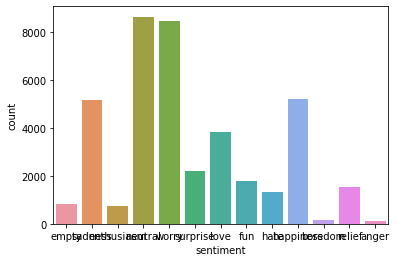

In [214]:
sns.countplot(x='sentiment', data=dataset_2)

In [215]:
train, test = train_test_split(dataset_2, test_size= 0.3, random_state=111)
train, val = train_test_split(train, test_size=0.3, random_state=111)

In [274]:
dataset_2['content'] = dataset_2['content'].apply(lambda x: preprocess_text(x))

In [275]:
dataset_2

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,tiffanylue know was listenin to bad habit ear...
1,1956967666,sadness,wannamama,layin bed with headache ughhhh waitin on your ...
2,1956967696,sadness,coolfunky,funeral ceremony gloomy friday
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends soon
4,1956968416,neutral,xkilljoyx,dannycastillo we want to trade with someone w...
...,...,...,...,...
39995,1753918954,neutral,showMe_Heaven,johnlloydtaylor
39996,1753919001,love,drapeaux,happy mothers day all my love
39997,1753919005,love,JenniRox,happy mother day to all the mommies out there ...
39998,1753919043,happiness,ipdaman1,niariley wassup beautiful follow me peep out ...


In [276]:
X_train = train.content
X_test = test.content
X_val = val.content

y_train = train.sentiment
y_test = test.sentiment
y_val = val.sentiment

In [277]:
from sklearn.utils import class_weight
class_weights = list(class_weight.compute_class_weight(
    class_weight = 'balanced', 
    classes = np.unique(dataset_2['sentiment']), 
    y = dataset_2['sentiment']))

In [278]:
dataset_2.sentiment.unique()

array(['empty', 'sadness', 'enthusiasm', 'neutral', 'worry', 'surprise',
       'love', 'fun', 'hate', 'happiness', 'boredom', 'relief', 'anger'],
      dtype=object)

In [279]:
class_weights.sort()

In [280]:
class_weights

[0.3562078116373092,
 0.3637454872825484,
 0.5906936219856166,
 0.5957256683297342,
 0.8008649341288592,
 1.4069149871619007,
 1.7325017325017324,
 2.0163322915616493,
 2.3257166114308974,
 3.7205841317086783,
 4.053917097395359,
 17.189514396218307,
 27.972027972027973]

In [281]:
weights = {}

for index, weight in enumerate(class_weights):
    weights[index] = weight

In [282]:
dataset_train = tf.data.Dataset.from_tensor_slices((train['content'].values, train['sentiment'].values))
dataset_test = tf.data.Dataset.from_tensor_slices((test['content'].values, test['sentiment'].values))
dataset_val = tf.data.Dataset.from_tensor_slices((val['content'].values, val['sentiment'].values))

In [283]:
for text, target in dataset_train.take(7
):
    print(f'Text: {text}, Emotion: {target}')

Text: b'Is getting ready for work... Working all weekend', Emotion: b'neutral'
Text: b"@happy_pills we have a punching bag here! but ive never touched it, covered with my brother's sweat.. but u can use it if u want! hehe", Emotion: b'happiness'
Text: b'@Mollieandme When oh when are you coming back for a gig in Scotland? I had tickets to see u last year but was in hosp wit gallstones!', Emotion: b'neutral'
Text: b"@purpleshoe Ahh! normally I would jump at that but i'm manning the office solo today", Emotion: b'worry'
Text: b"Here's @Euan and @stoweboyd at our evening drink on Thursday night in London.  http://twitpic.com/4wrrp", Emotion: b'happiness'
Text: b'Memorizing the first 18 lines of the General Prologue of The Canterbury Tales. Ughhh.', Emotion: b'worry'
Text: b'So tired. Work today.', Emotion: b'worry'


In [284]:
table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(['empty', 'sadness', 'enthusiasm', 'neutral', 'worry', 'surprise','love', 'fun', 'hate', 'happiness', 'boredom', 'relief', 'anger']),
        values=tf.constant([0,1,2,3,4,5,6,7,8,9,10,11,12]),
    ),
    default_value=tf.constant(-1),
    name = "target_encoding"
)

@tf.function
def target(x):
    return table.lookup(x)

In [285]:
def show_batch(dataset, size=5):
    for batch, label in dataset.take(size):
        print(batch.numpy())
        print(target(label).numpy())

In [286]:
show_batch(dataset_test, 12)

b'... I will launch (make or break) the alpha phase of my residential real estate rental website. (Commitment of first grade'
4
b"@hughsbeautiful Oherr it's soon then, do you have plans? I had a party on saturday  x"
3
b'This thunder is scaring the hell out of me...geez...I HATE THUNDER  we better not loose electricity... #fb http://myloc.me/2144'
5
b'@Streyeder You rock my socks off! Sorry you have to go to BFE Maryland.'
3
b"@orbitaldiamonds I want all the soldiers to come home so we don't have to hear about anymore being killed."
4
b"Nic has no idea what he's going to do!  money is all gone!"
4
b'massive headache  going to see terminator tonight!'
9
b'I really want to be a star...Hope Flawless will work'
9
b'sees your Steve Coogan and raises you a Dylan Moran.'
3
b'@DChi606 Sadly, all I have is the Stanley Steemer 800 number.'
3
b'@jojototh @abduzeedo firefox ok, but opera and IE - footer is not ok'
8
b"Happy Mother's Day one day early to all moms everywhere---you deserve to have yo

In [287]:
def fetch(text, labels):
    return text, tf.one_hot(target(labels), 13)

In [288]:
train_data_f = dataset_train.map(fetch)
test_data_f = dataset_test.map(fetch)
val_data_f = dataset_val.map(fetch)

In [289]:
next(iter(train_data_f))

(<tf.Tensor: shape=(), dtype=string, numpy=b'Is getting ready for work... Working all weekend'>,
 <tf.Tensor: shape=(13,), dtype=float32, numpy=array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>)

In [290]:
train_data, train_labels = next(iter(train_data_f.batch(5)))
train_data, train_labels

(<tf.Tensor: shape=(5,), dtype=string, numpy=
 array([b'Is getting ready for work... Working all weekend',
        b"@happy_pills we have a punching bag here! but ive never touched it, covered with my brother's sweat.. but u can use it if u want! hehe",
        b'@Mollieandme When oh when are you coming back for a gig in Scotland? I had tickets to see u last year but was in hosp wit gallstones!',
        b"@purpleshoe Ahh! normally I would jump at that but i'm manning the office solo today",
        b"Here's @Euan and @stoweboyd at our evening drink on Thursday night in London.  http://twitpic.com/4wrrp"],
       dtype=object)>,
 <tf.Tensor: shape=(5, 13), dtype=float32, numpy=
 array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]],
  

In [291]:
model_LTSM.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.7), 
        loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])

In [292]:
train_data_f = train_data_f.shuffle(70000).batch(512)
test_data_f = test_data_f.batch(512)
val_data_f = val_data_f.batch(512)

In [302]:
history = model2.fit(train_data_f,
                    epochs=200,
                    validation_data = val_data_f,
                    verbose = 1,
                    class_weight = weights)

Epoch 1/200
39/39 [==============================] - 57s 1s/step - loss: 0.8485 - accuracy: 0.6334 - val_loss: 6.6225 - val_accuracy: 0.2164
Epoch 2/200
39/39 [==============================] - 54s 1s/step - loss: 0.8478 - accuracy: 0.6323 - val_loss: 6.3248 - val_accuracy: 0.2186
Epoch 3/200
39/39 [==============================] - 56s 1s/step - loss: 0.8276 - accuracy: 0.6402 - val_loss: 6.7996 - val_accuracy: 0.2152
Epoch 4/200
39/39 [==============================] - 54s 1s/step - loss: 0.8174 - accuracy: 0.6412 - val_loss: 6.8972 - val_accuracy: 0.2170
Epoch 5/200
39/39 [==============================] - 54s 1s/step - loss: 0.7996 - accuracy: 0.6456 - val_loss: 6.8107 - val_accuracy: 0.2205
Epoch 6/200
39/39 [==============================] - 55s 1s/step - loss: 0.8337 - accuracy: 0.6374 - val_loss: 6.7859 - val_accuracy: 0.2173
Epoch 7/200
39/39 [==============================] - 53s 1s/step - loss: 0.8059 - accuracy: 0.6518 - val_loss: 6.9447 - val_accuracy: 0.2155
Epoch 8/200
3

In [271]:
dataset_2

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,tiffanylue know was listenin to bad habit ear...
1,1956967666,sadness,wannamama,Layin bed with headache ughhhh waitin on your ...
2,1956967696,sadness,coolfunky,Funeral ceremony gloomy friday
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON
4,1956968416,neutral,xkilljoyx,dannycastillo We want to trade with someone w...
...,...,...,...,...
39995,1753918954,neutral,showMe_Heaven,JohnLloydTaylor
39996,1753919001,love,drapeaux,Happy Mothers Day All my love
39997,1753919005,love,JenniRox,Happy Mother Day to all the mommies out there ...
39998,1753919043,happiness,ipdaman1,niariley WASSUP BEAUTIFUL FOLLOW ME PEEP OUT ...


In [303]:
test_batch = len(dataset_2)

results = model2.evaluate(dataset_test.map(fetch).batch(test_batch), verbose=2)
print(results)

1/1 - 1s - loss: 14.5684 - accuracy: 0.1974 - 870ms/epoch - 870ms/step
[14.568422317504883, 0.19741666316986084]


In [304]:
test_data, test_labels = next(iter(dataset_2.map(fetch).batch(45963)))

AttributeError: 'DataFrame' object has no attribute 'map'

In [ ]:
y_pred = model2.predict(test_data)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_labels.numpy().argmax(axis=1), y_pred.argmax(axis=1)))